In [1]:
####### IMPORT #######
import networkx as nx
from gerrychain import Graph
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

from util import update_attributes, get_k_L_U
from sketch import sketch
from clusterings import clusterings

filepath = 'C:\\districting-data-2020\\'

In [2]:
####### PICK A STATE #######
from number_of_districts import congressional_districts_2020
states = sorted([ state for state in congressional_districts_2020.keys() ])

results = dict()
instances = [('TN','SS')] 
for (state, district_type) in instances: 

    print("**********************************")
    print("State:",state,"district_type:",district_type)
    print("**********************************")
    filename = state + '_county.shp'
    df = gpd.read_file( filepath + filename )
    
    # get county graph
    filename = state + '_county.json'
    GC = Graph.from_json( filepath + filename )
    update_attributes(GC, state)    
    (k, L, U) = get_k_L_U(GC, state, district_type)
    
    if k <= 1 or not nx.is_connected(GC):
        print("Skipping this state because k <= 1 or because graph is disconnected.")
        continue

    clusters = clusterings[state,district_type]['clusters']
    sizes = clusterings[state,district_type]['sizes'] 

**********************************
State: TN district_type: SS
**********************************
Starting TN with k = 33 and deviation = 0.1
Thus, we have L = 198949 and U = 219890


Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-27


<ipython-input-3-42600052abd7>:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figureObject, axesObject = plt.subplots()


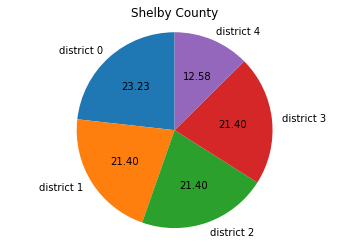

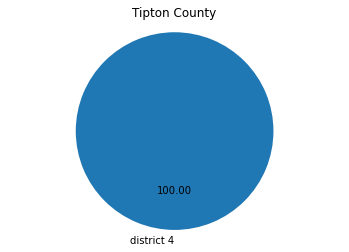

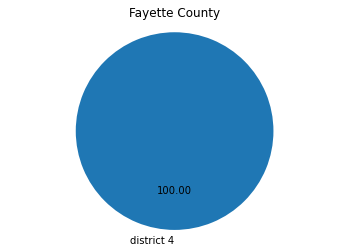

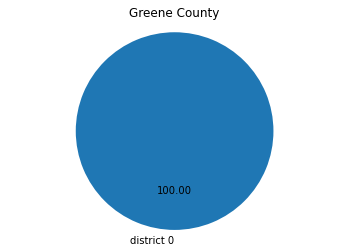

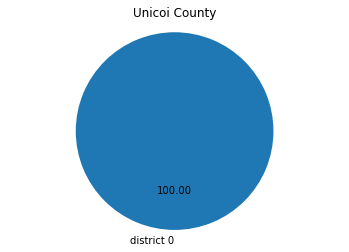

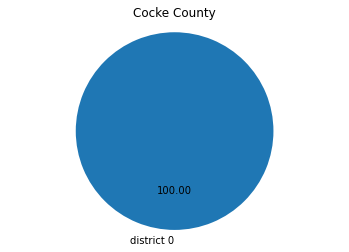

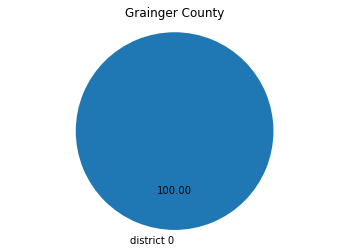

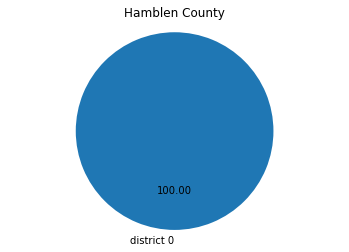

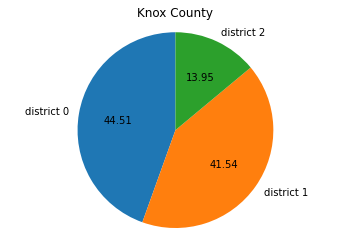

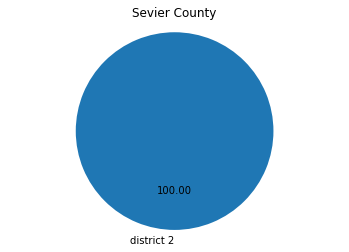

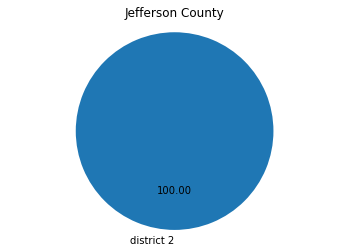

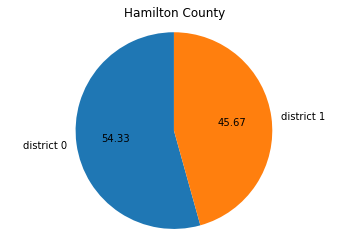

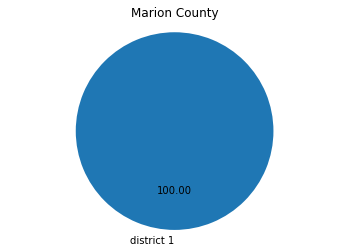

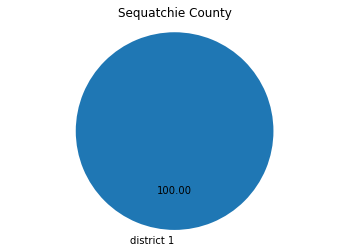

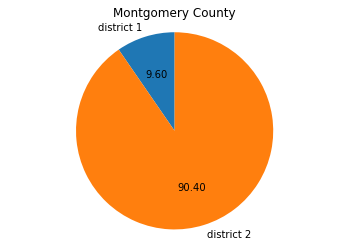

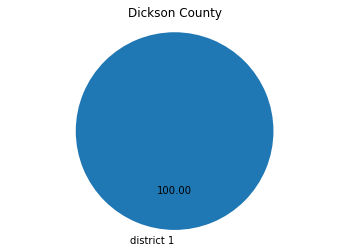

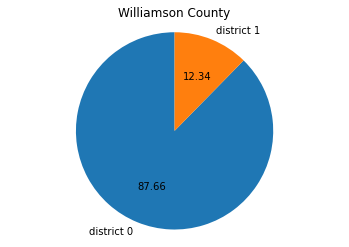

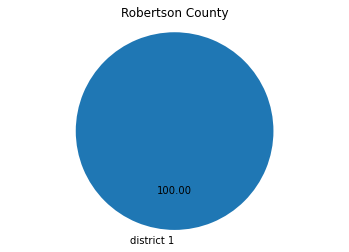

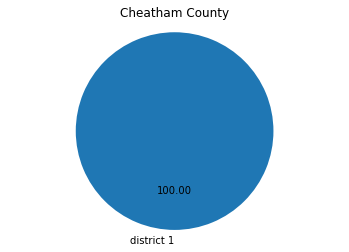

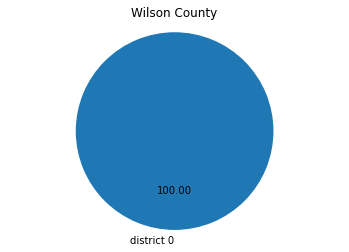

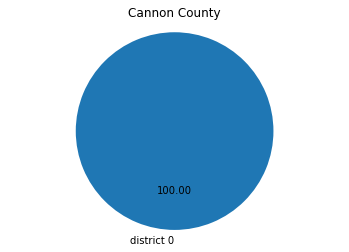

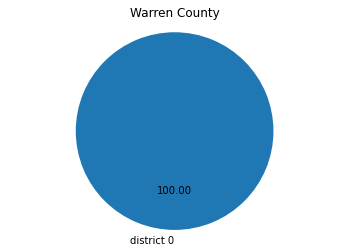

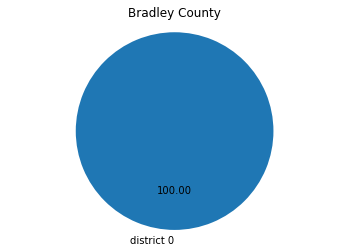

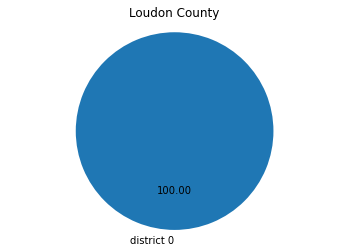

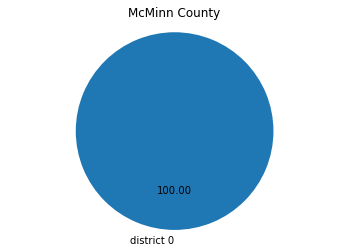

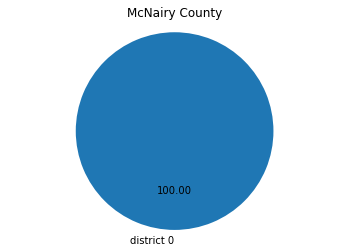

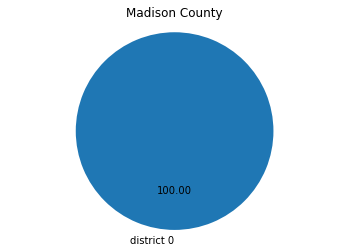

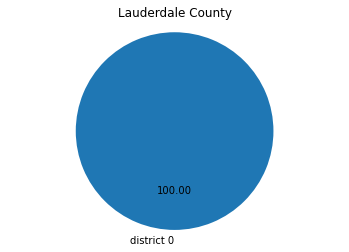

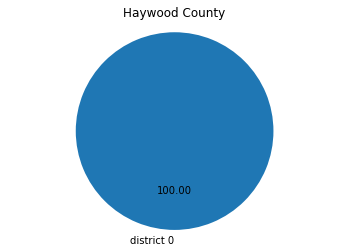

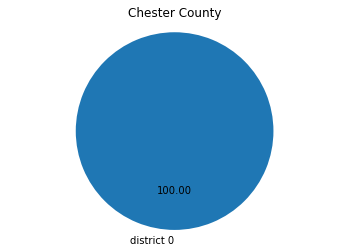

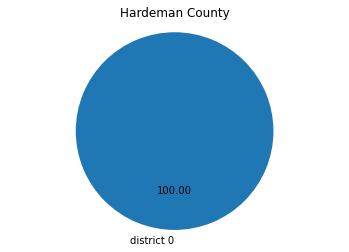

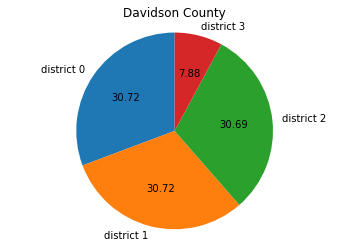

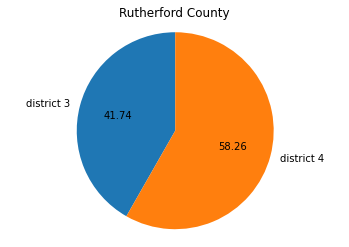

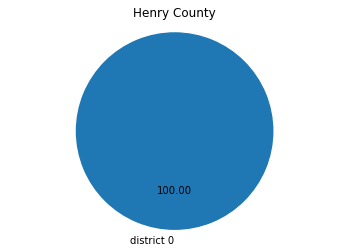

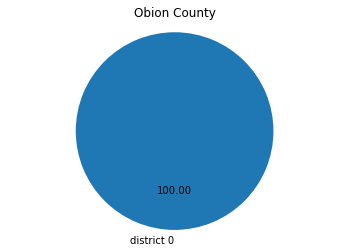

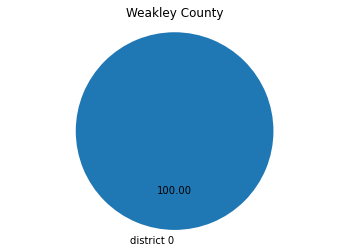

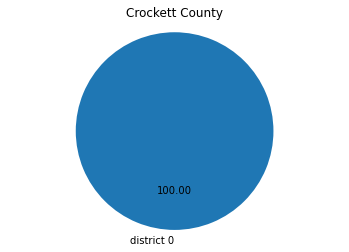

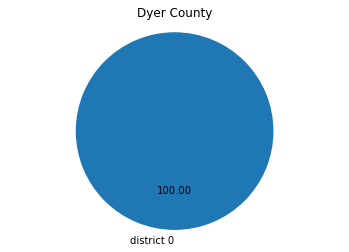

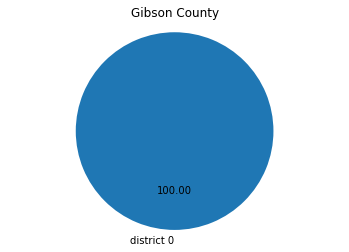

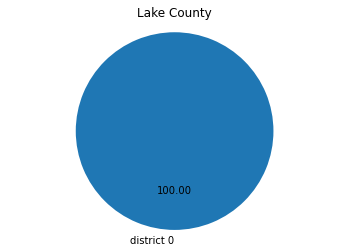

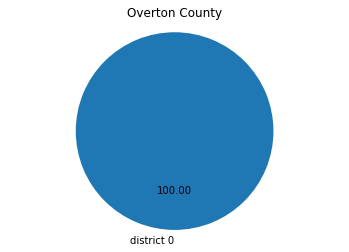

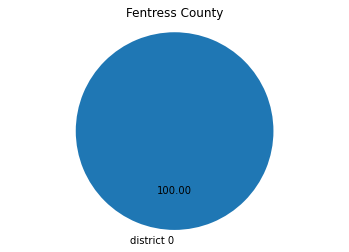

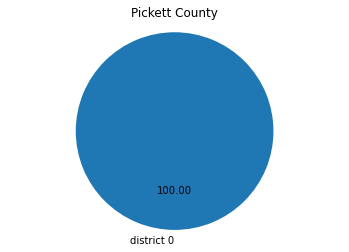

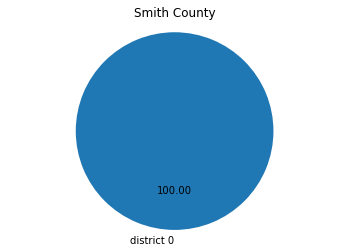

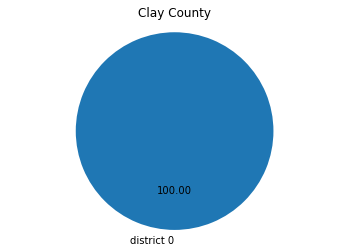

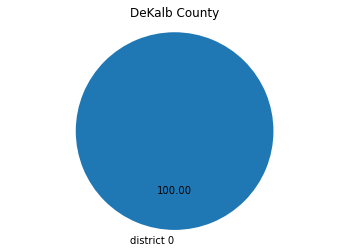

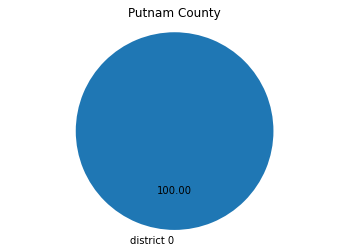

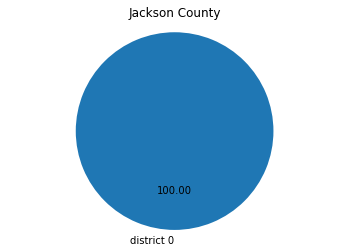

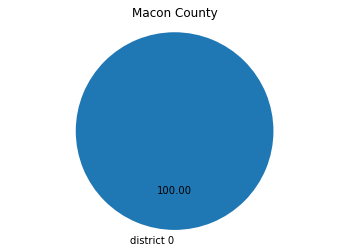

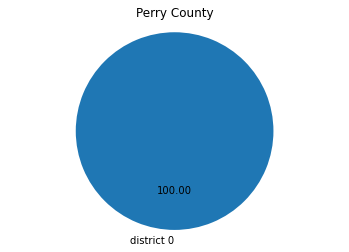

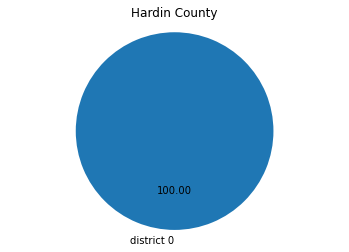

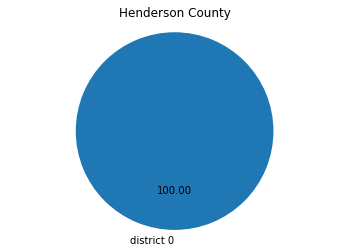

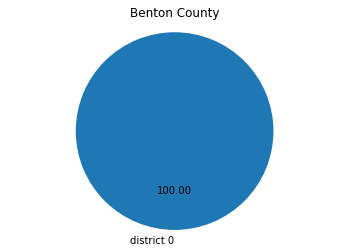

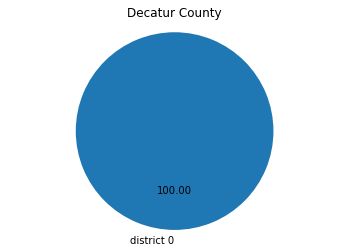

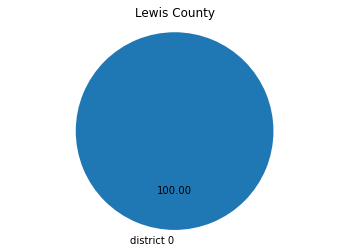

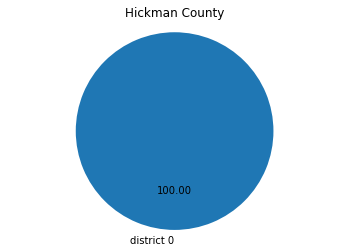

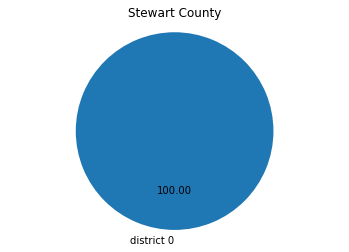

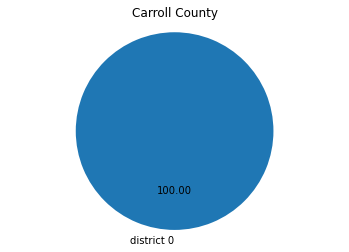

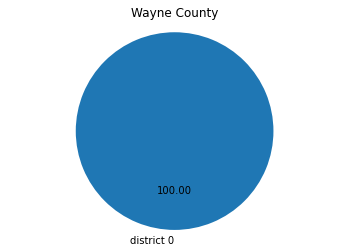

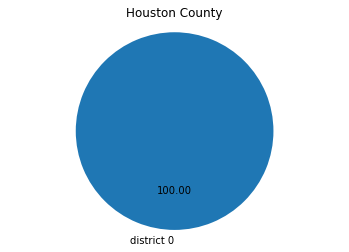

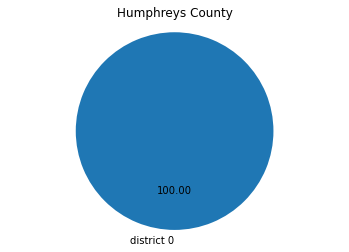

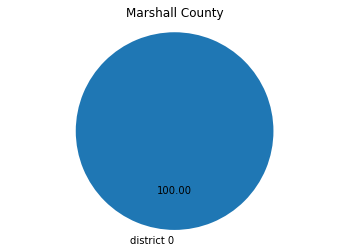

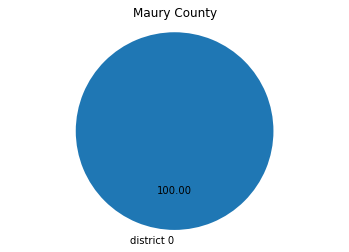

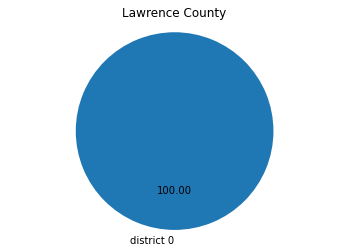

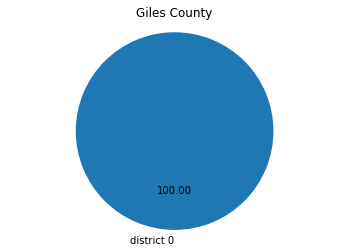

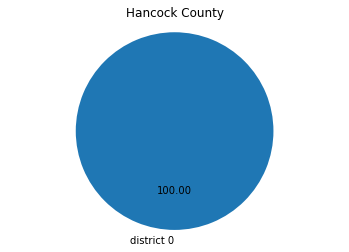

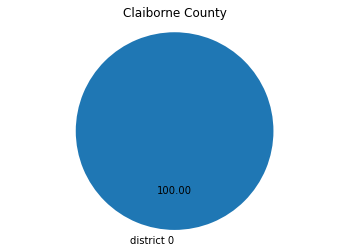

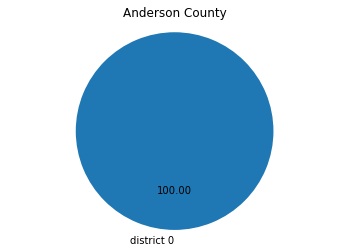

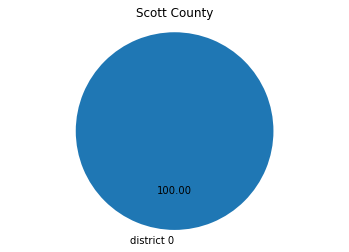

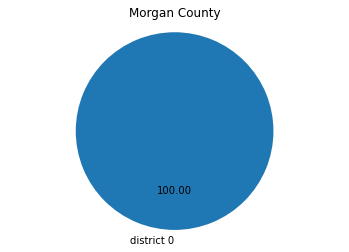

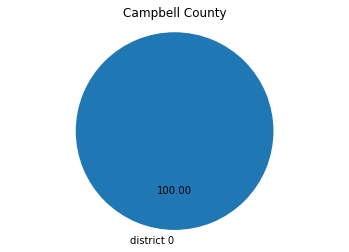

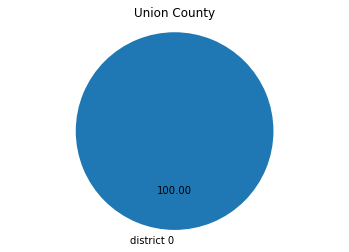

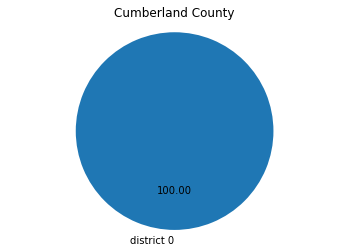

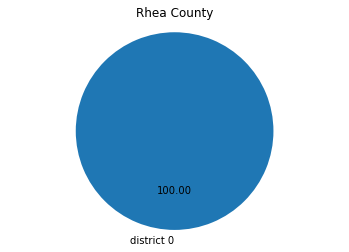

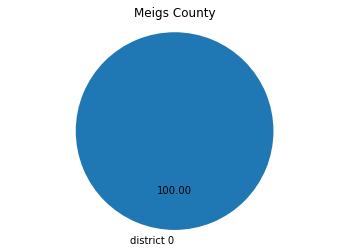

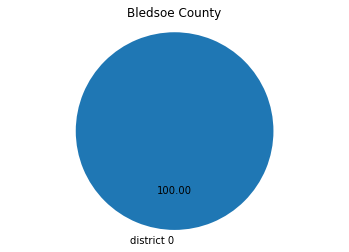

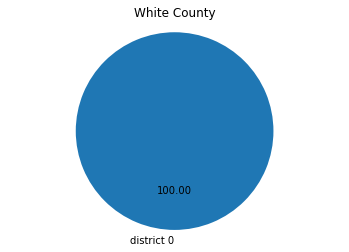

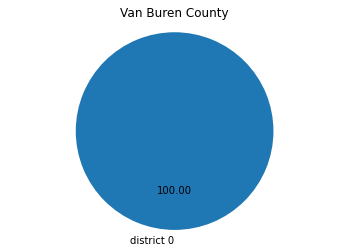

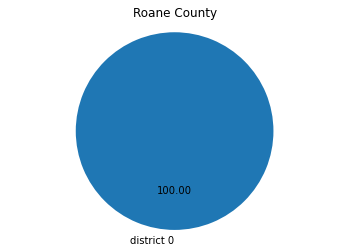

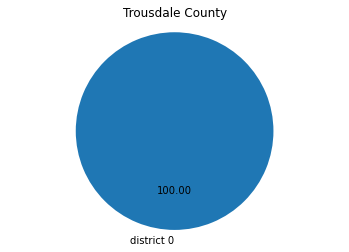

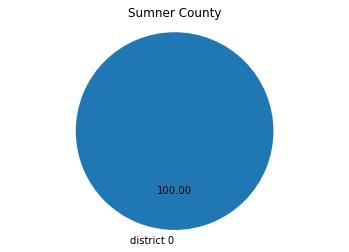

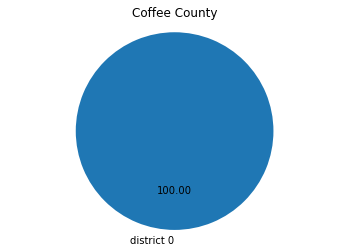

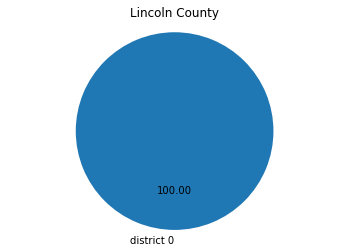

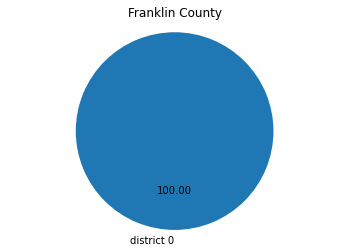

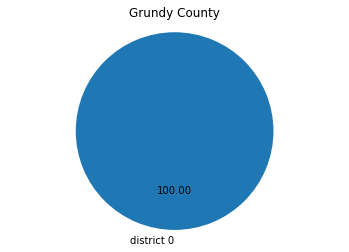

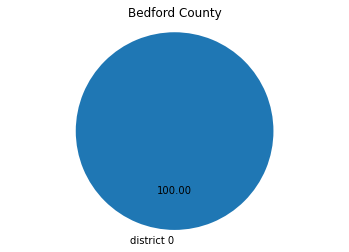

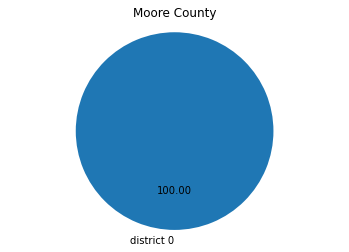

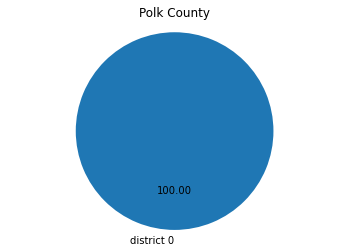

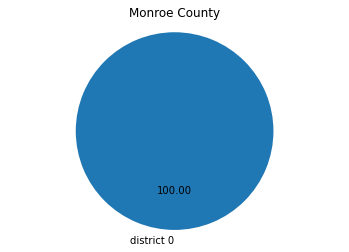

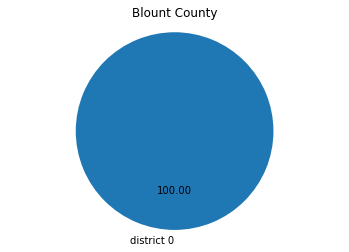

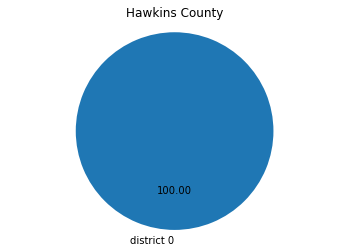

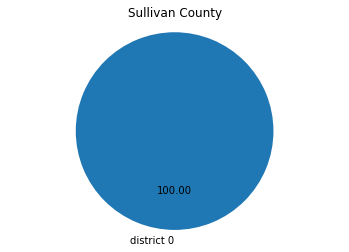

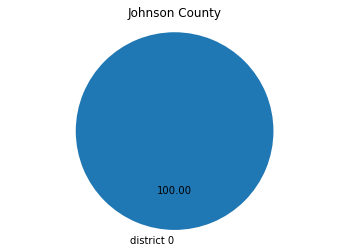

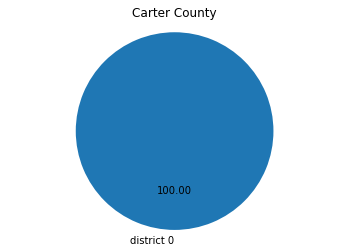

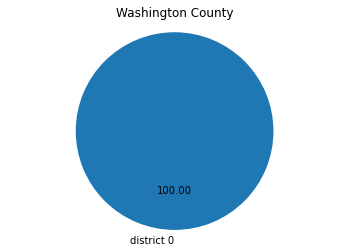

In [3]:
####### COUNTY ZOOM-INS PIE CHART #######
def pie (clusters, sizes, GC, L, U):
    
    for p in range(len(clusters)):
        cluster = clusters[p]
        size = sizes[p]
        GS = GC.subgraph(cluster)
        (xsoln, ysoln, zsoln) = sketch(GS, L, U, size)

        for i in GC.nodes:
            
            if i in zsoln:    
                pieLabels = [ "district"+ " " + str(list(zsoln[i].keys())[l]) for l in range(len(zsoln[i])) ]
                populationShare =[ zsoln[i].get(j) for j in range(k) if zsoln[i].get(j) != None ]
                figureObject, axesObject = plt.subplots()
                plt.title( GC.nodes[i]["NAME"] )
                axesObject.pie(populationShare, labels=pieLabels, autopct='%1.2f', startangle=90, normalize=False)
                axesObject.axis('equal')
                
            else:
                continue
                
    return axesObject

axesObject = pie (clusters, sizes, GC, L, U)

In [4]:
####### COLOR FOR PIE CHART #######
crit = np.array([16,17,18,19,30,4,2,3,32,5,11,27,10,20,21,24,34,13,8,29,1,31,9,33,14,12,7,35,15,28,6,23,22,25,26,36,37,38,39,40,41,42])

color_dict = {'1':'#e6f2ff', '2':'#99ccff', '3':'#ccccff','4':'#cc99ff', '5':'#ff99ff', '6':'#ff6699', '7':'#ff9966',
              '8':'#ff6600', '9':'#ff5050', '10':'#ff0000', '11':'#bc8f8f', '12': '#ff69b4','13': 'cyan', '14': '#81ffc3',
              '15':'#2e8b57', '16':'#eeefff', '17':'#da70d6', '18':'#ff7f50', '19':'#cd853f', '20':'#5f9ea0', '21':'#daa520',
              '22':'#bdff81', '23':'#cde5ff', '24': '#81bdff', '25':'#33664e', '26':'#572e52', '27':'#2e3e57', '28':'#FDF8C8',
              '29':'#57332e', '30':'#1c3336', '31':'#2e5748', '32':'#895048', '33':'#572e3e', '34':'#a14462', '35':'#2d6b57',
              '36':'#faebd7', '37':'#FFFFFF', '38':'#81fcff', '39':'#ff8481', '40':'#8481ff', '41':'#3935ff', '42':'#000000'}

piecolors = np.array([''] * len(crit), dtype = object)
for i in np.unique(crit):
    piecolors[np.where(crit == i)] = color_dict[str(i)]

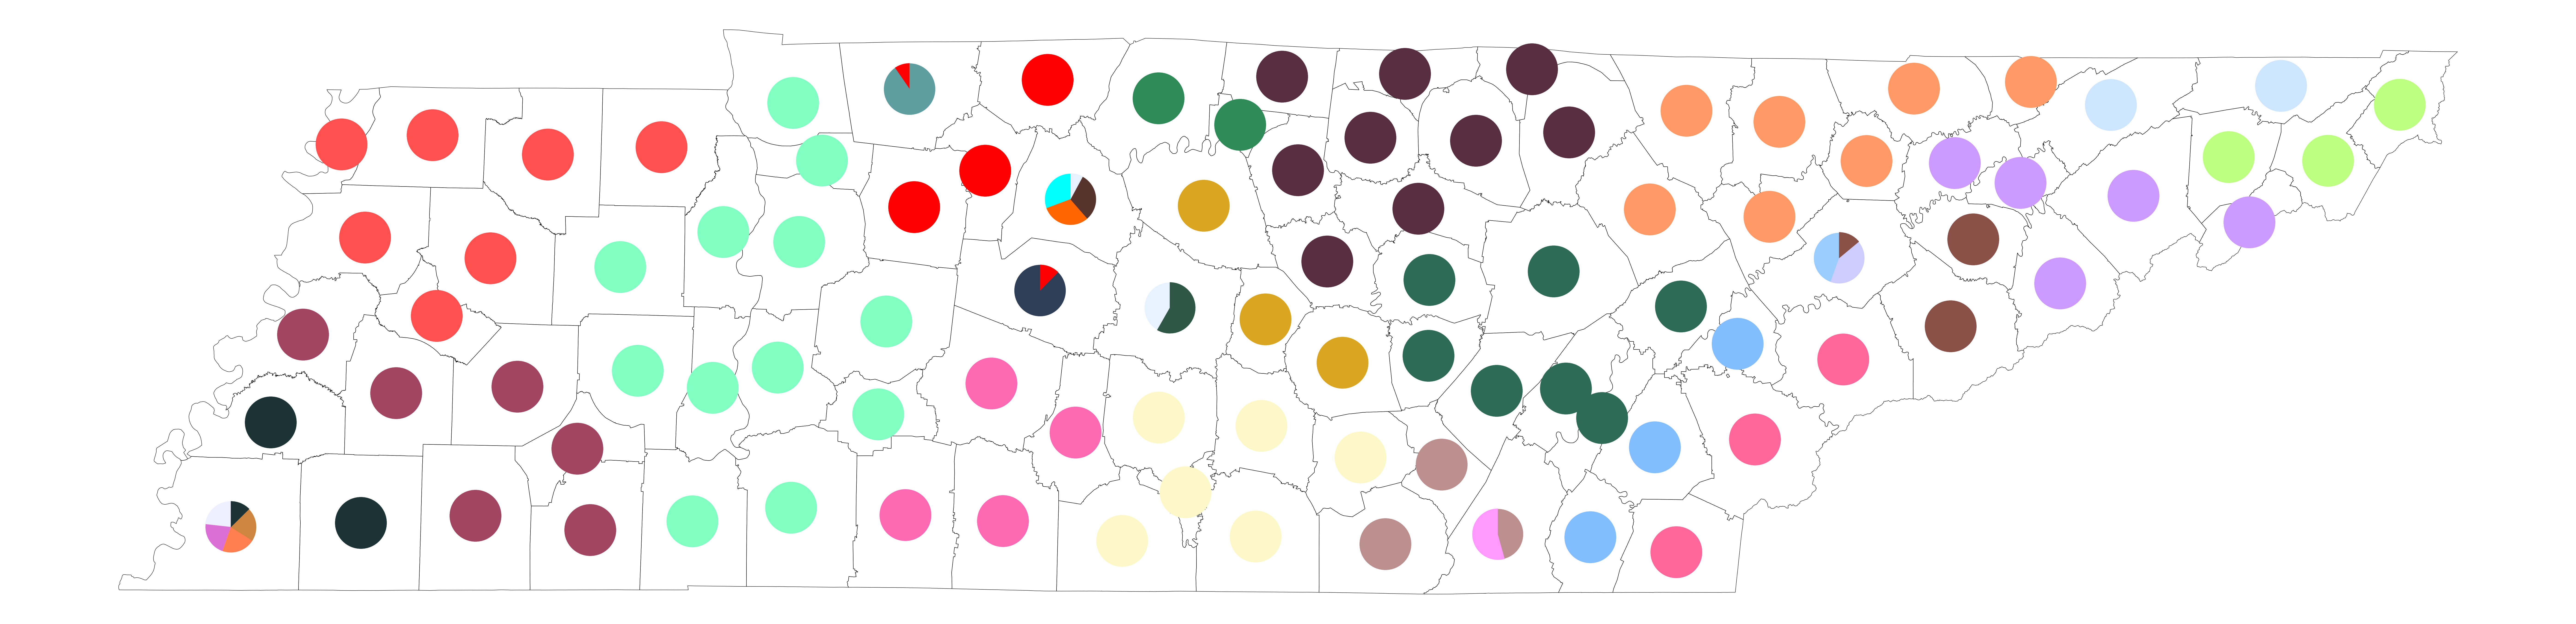

In [5]:
####### FINAL STATE-WIDE SKETCH MAP #######

# drawing the state map
plt.rcParams["figure.figsize"] = [200, 700]
fig, ax = plt.subplots()
df.boundary.plot(ax=ax, zorder=1, edgecolor='black') 
ax.axis('off')

# insert the pie chart to the related county
for p in range(len(clusters)):
    
    cluster = clusters[p]
    size = sizes[p]
    GS = GC.subgraph(cluster)
    (xsoln, ysoln, zsoln) = sketch(GS, L, U, size)

    for i in GC.nodes: 
       
        if i in zsoln:
            x_coord = GC.nodes[i]['C_X']
            y_coord = GC.nodes[i]['C_Y']
            
            for j in range(len(zsoln[i])):

                pieLabels = [ "district"+ " " + str(list(zsoln[i].keys())[l]) for l in range(len(zsoln[i])) ]
                populationShare =[ zsoln[i].get(j) for j in range(k) if zsoln[i].get(j) != None ]
                wedges= axesObject.pie(populationShare, labels=pieLabels, autopct='%1.2f', startangle=90, normalize= False)
                
                # for the first cluster
                if p==0:
                    ax.scatter([x_coord], [y_coord], marker=(wedges[0][j].get_path()),
                               color= piecolors[(list(zsoln[i].keys())[j])], s=50000)
                    
                # for other clusters add the number of pervious clusters' sizes    
                else:
                    ax.scatter([x_coord],[y_coord], marker=(wedges[0][j].get_path()),
                           color= piecolors[(list(zsoln[i].keys())[j])+ sum(sizes[p-l-1] for l in range(p))], s=50000)
plt.savefig("map.png")